In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from typing import Optional, TypedDict, Literal
import matplotlib.pyplot as plt
import pandas as pd
import re
import os

import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": False,  # Don't interpret text with LaTeX
    "pgf.rcfonts": False,  # Use current matplotlib font
})

from eval.calculate_samples import calculate_stats, Stats, StatsScore

In [3]:
eval_dir = 'outputs/eval_samples'
output_path = '../outputs/eval_stats'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [11]:
num_steps = [10, 50, 100, 1000]
# models = ['bubbles', 'room_type', 'combined']
models = ['room_type', 'combined']

names = {
    'bubbles': 'Bubbles Only',
    'room_type': 'Room Types',
    'combined': 'Bubbles'
}

outputs = {}
for model in models:
    for step in num_steps:
        for conditioned in [True, False]:
            for ddpm in [True, False]:
                path = f"{eval_dir}/sample_{model}_{step}"
                if not conditioned:
                    path += '_unconditioned'
                if ddpm:
                    path += '_ddpm'
                if not os.path.exists(path):
                    continue
                name = f"{names[model]} {step} {'Conditioned' if conditioned else 'Unconditioned'}{' DDPM' if ddpm else ''}"
                outputs[name] = path

outputs['House Diffusion'] = '../outputs/house_diffusion'
outputs['HouseGAN++'] = '../outputs/houseganpp'

In [12]:
fid_stats = {name: calculate_stats(path, Stats.FID, save_path=output_path, device=device) for name, path in
             outputs.items()}

sample_idk2_100: 100%|██████████| 1/1 [00:33<00:00, 33.89s/run]


In [24]:
kid_stats = {name: calculate_stats(path, Stats.KID, save_path=output_path, device=device) for name, path in
             outputs.items()}

In [25]:
def make_pivots(fid: dict[str, StatsScore], kid: dict[str, StatsScore], omit_others: bool = False) -> tuple[
    pd.DataFrame, pd.DataFrame]:
    rows = []
    for key in fid_stats.keys():
        fid_score = fid[key]
        kid_score = kid[key]
        match = re.search(r'^(.*) (\d+) (Unconditioned|Conditioned) ?(DDPM)?$', key)
        if match:
            model, step, condition, ddpm = match.groups()
            step = int(step)
            column = f"{model} {condition} {ddpm if ddpm else ''}".strip()
        else:
            if omit_others:
                continue
            step = 1000
            column = key
        fid_value = f"{fid_score.mean:.2f} ± {fid_score.sem:.2f}"
        kid_value = f"{kid_score.mean:.4f} ± {kid_score.sem:.4f}"
        rows.append({
            'steps': step,
            'Model': column.replace("_", " "),
            'fid': fid_value,
            'kid': kid_value
        })

    data = pd.DataFrame(rows)

    def reorder_columns(df: pd.DataFrame) -> pd.DataFrame:
        columns = [col for col in df.columns if not 'DDPM' in col] + [col for col in df.columns if 'DDPM' in col]
        return df[columns]

    fid_pivot = reorder_columns(data.pivot(index='steps', columns='Model', values='fid'))
    kid_pivot = reorder_columns(data.pivot(index='steps', columns='Model', values='kid'))

    fid_pivot = fid_pivot.sort_index()
    kid_pivot = kid_pivot.sort_index()

    return fid_pivot, kid_pivot


def get_best_scores(fid: pd.DataFrame, kid: pd.DataFrame) -> tuple[pd.Series, pd.Series]:
    def extract_min(value):
        if pd.isna(value):
            return float('inf')  # or np.nan depending on preference
        return float(value.split('±')[0].strip())

    min_fid = fid.apply(lambda col: col.loc[col.map(extract_min).idxmin()])
    min_kid = kid.apply(lambda col: col.loc[col.map(extract_min).idxmin()])

    def sort_rows(s: pd.Series) -> pd.DataFrame:
        values = s.str.extract(r"([0-9.]+)\s*±")[0].astype(float)

        # Sort the Series by these extracted values
        s_sorted = s.loc[values.sort_values(ascending=True).index]
        return s_sorted

    min_fid = sort_rows(min_fid)
    min_kid = sort_rows(min_kid)
    return min_fid, min_kid

In [26]:
all_fid, all_kid = make_pivots(fid_stats, kid_stats, omit_others=True)
best_fid_pivot, best_kid_pivot = make_pivots(fid_stats, kid_stats, omit_others=False)
best_fid, best_kid = get_best_scores(best_fid_pivot, best_kid_pivot)

In [71]:
def plot_df(df: pd.DataFrame, ylabel: str, title: Optional[str] = None, figsize=(10, 6)):
    means: pd.DataFrame = df.apply(lambda x: x.str.extract(r"([0-9.]+)\s*±\s*([0-9.]+)").astype(float)[0], axis=0)
    errors = df.apply(lambda x: x.str.extract(r"([0-9.]+)\s*±\s*([0-9.]+)").astype(float)[1], axis=0)

    fig, ax = plt.subplots(figsize=figsize)
    fig.tight_layout()
    means.plot(kind='bar', yerr=errors, capsize=10, width=1, xlabel='Steps', ylabel=ylabel, title=title, ax=ax)


def plot_values(df: pd.DataFrame, xlabel: str, title: Optional[str] = None, figsize=(10, 6)):
    vals = df.str.extract(r'([0-9.]+)\s*±\s*([0-9.]+)').astype(float)
    vals.columns = ['mean', 'error']
    vals.index = df.index  # preserve original model names

    # Step 3: Plot with error bars
    ax = vals['mean'].plot(
        kind='barh',
        xerr=vals['error'],
        capsize=5,
        color='cornflowerblue',
        edgecolor='black',
        xlabel=xlabel,
        title=title,
        figsize=figsize
    )


class ModelColumn(TypedDict):
    key: str
    name: str


def make_table(df: pd.DataFrame, models: dict[str, ModelColumn], bold_list: list[tuple[str, str, bool]]) -> str:
    output = f"\\begin{{tabular}}{{{'|'.join(['c'] + ['cc'] * len(models))}}}\n"
    output += f"\t\\textbf{{Steps}} & {' & '.join([f'\\multicolumn{{2}}{{c}}{{\\textbf{{{model['name']}}}}}' for model in models.values()])} \\\\\n"
    output += f"\t & {' & '.join([f'\\textbf{{Unconditioned}} & \\textbf{{Conditioned}}' for _ in models])} \\\\\n"
    output += f"\t\\hline\n"

    def process_values(step: str,
                       values: dict[str, dict[Literal['Unconditioned', 'Conditioned'], tuple[str, str]]]) -> str:

        def format_values(value: tuple[str, str], bold: bool = False) -> str:
            s = f"{value[0]} \\pm {{\\small {value[1]}}}"
            return f"\\textbf{{{s}}}" if bold else s

        row = f"{step} & "
        for model in models.values():
            if model['key'] in values:
                uncond, cond = values[model['key']]['Unconditioned'], values[model['key']]['Conditioned']
                row += f"{format_values(uncond, (model["key"], step, False) in bold_list) if uncond else '---'} & {format_values(cond, (model["key"], step, True) in bold_list) if cond else '---'} & "
            else:
                row += " & ".join(["--"] * 2) + " & "

        return row[:-2] + "\\\\\n"

    for step in sorted(df.index):
        values = {}
        for column in df.columns:
            ddpm = 'DDPM' in column
            if ddpm:
                continue

            match = re.match(r'^(.*) (Unconditioned|Conditioned)$', column)
            if not match:
                continue
            model_name, condition = match.groups()
            if model_name not in models:
                continue

            model = models[model_name]
            value = str(df.at[step, column])

            match = re.match(r'([0-9.]+) ± ([0-9.]+)', value)
            if not match:
                continue
            mean, error = match.groups()
            if model['key'] not in values:
                values[model['key']] = {'Unconditioned': '', 'Conditioned': ''}
            values[model['key']][condition] = (mean, error)
        output += f"\t\t{process_values(str(step), values)}"

    values = {}
    for column in df.columns:
        ddpm = 'DDPM' in column
        if not ddpm:
            continue

        match = re.match(r'^(.*) (Unconditioned|Conditioned) DDPM$', column)
        if not match:
            continue
        model_name, condition = match.groups()
        if model_name not in models:
            continue

        model = models[model_name]
        value = str(df.at[step, column])
        match = re.match(r'([0-9.]+) ± ([0-9.]+)', value)
        if not match:
            continue
        mean, error = match.groups()
        if model['key'] not in values:
            values[model['key']] = {'Unconditioned': '', 'Conditioned': ''}
        values[model['key']][condition] = (mean, error)
    output += f"\t\t{process_values('1000 (DDPM)', values)}"

    output += "\\end{tabular}\n"
    return output




In [73]:
model_dict = {
    'Room Types': {'key': 'room_type', 'name': 'Room Types'},
    'Bubbles': {'key': 'bubbles', 'name': 'Bubbles'},
}
bold_list = [
    ('room_type', '100', True),
    ('room_type', '1000 (DDPM)', True),
    ('bubbles', '100', True),
]

print(make_table(all_fid, model_dict, bold_list))
print(make_table(all_kid, model_dict, bold_list))

\begin{tabular}{c|cc|cc}
	\textbf{Steps} & \multicolumn{2}{c}{\textbf{Room Types}} & \multicolumn{2}{c}{\textbf{Bubbles}} \\
	 & \textbf{Unconditioned} & \textbf{Conditioned} & \textbf{Unconditioned} & \textbf{Conditioned} \\
	\hline
		10 & 26.53 \pm {\small 0.20} & 25.78 \pm {\small 0.24} & 18.53 \pm {\small 0.07} & 16.56 \pm {\small 0.03} \\
		50 & 17.83 \pm {\small 0.15} & 15.59 \pm {\small 0.08} & 16.18 \pm {\small 0.09} & 16.70 \pm {\small 0.09} \\
		100 & 17.69 \pm {\small 0.11} & \textbf{14.74 \pm {\small 0.14}} & 16.16 \pm {\small 0.09} & \textbf{14.36 \pm {\small 0.09}} \\
		1000 & --- & 13.90 \pm {\small 0.04} & 16.16 \pm {\small 0.15} & 15.85 \pm {\small 0.12} \\
		1000 (DDPM) & --- & \textbf{11.61 \pm {\small 0.04}} & --- & 14.81 \pm {\small 0.14} \\
\end{tabular}

\begin{tabular}{c|cc|cc}
	\textbf{Steps} & \multicolumn{2}{c}{\textbf{Room Types}} & \multicolumn{2}{c}{\textbf{Bubbles}} \\
	 & \textbf{Unconditioned} & \textbf{Conditioned} & \textbf{Unconditioned} & \textbf{Co

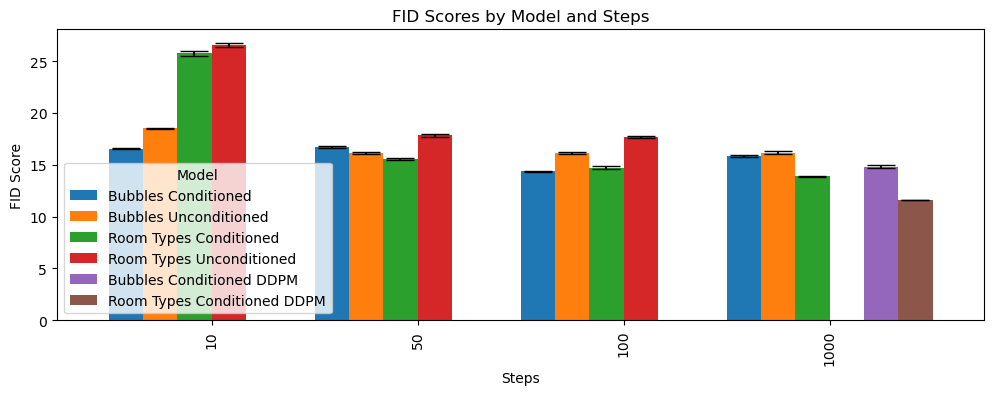

In [28]:
plot_df(all_fid, 'FID Score', 'FID Scores by Model and Steps', figsize=(10, 3.5))
plt.savefig('pgf/my_fid.pgf', transparent=True, bbox_inches='tight', pad_inches=0.0, backend='pgf')

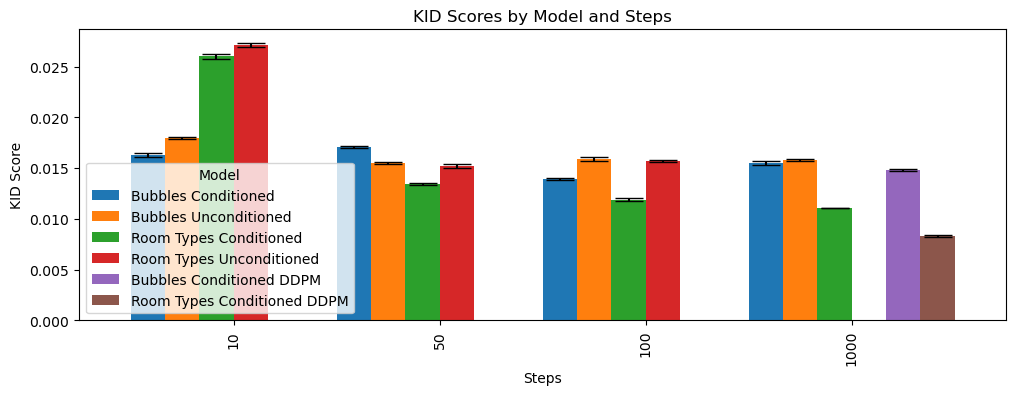

In [29]:
plot_df(all_kid, 'KID Score', 'KID Scores by Model and Steps', figsize=(10, 3.5))
plt.savefig('pgf/my_kid.pgf', transparent=True, bbox_inches='tight', pad_inches=0.0, backend='pgf')

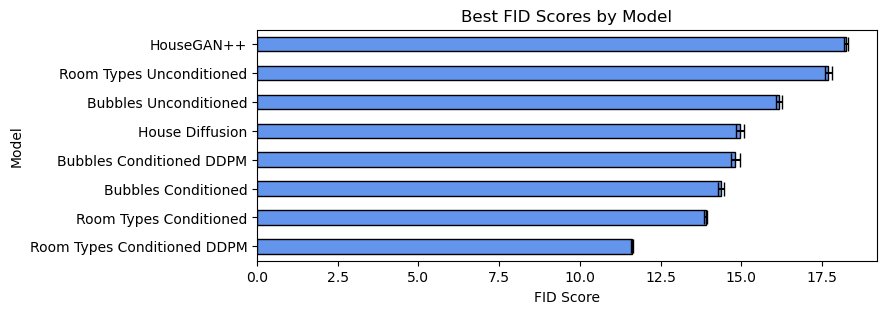

In [30]:
plot_values(best_fid, 'FID Score', 'Best FID Scores by Model', figsize=(8, 3))
plt.savefig('pgf/best_fid.pgf', transparent=True, bbox_inches='tight', pad_inches=0.0, backend='pgf')

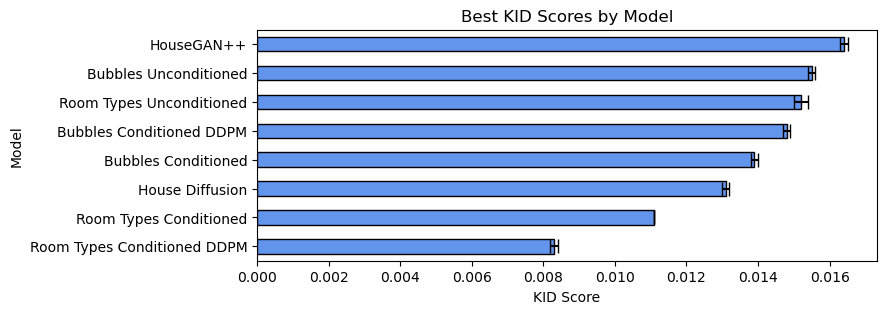

In [31]:
plot_values(best_kid, 'KID Score', 'Best KID Scores by Model', figsize=(8, 3))
plt.savefig('pgf/best_kid.pgf', transparent=True, bbox_inches='tight', pad_inches=0.0, backend='pgf')

In [32]:
all_fid

Model,Bubbles Conditioned,Bubbles Unconditioned,Room Types Conditioned,Room Types Unconditioned,Bubbles Conditioned DDPM,Room Types Conditioned DDPM
steps,,,,,,
10,16.56 ± 0.03,18.53 ± 0.07,25.78 ± 0.24,26.53 ± 0.20,NaN,NaN
50,16.70 ± 0.09,16.18 ± 0.09,15.59 ± 0.08,17.83 ± 0.15,NaN,NaN
100,14.36 ± 0.09,16.16 ± 0.09,14.74 ± 0.14,17.69 ± 0.11,NaN,NaN
1000,15.85 ± 0.12,16.16 ± 0.15,13.90 ± 0.04,NaN,14.81 ± 0.14,11.61 ± 0.04


In [33]:
all_kid

Model,Bubbles Conditioned,Bubbles Unconditioned,Room Types Conditioned,Room Types Unconditioned,Bubbles Conditioned DDPM,Room Types Conditioned DDPM
steps,,,,,,
10,0.0163 ± 0.0002,0.0180 ± 0.0001,0.0260 ± 0.0002,0.0271 ± 0.0002,NaN,NaN
50,0.0171 ± 0.0001,0.0155 ± 0.0001,0.0134 ± 0.0001,0.0152 ± 0.0002,NaN,NaN
100,0.0139 ± 0.0001,0.0159 ± 0.0002,0.0119 ± 0.0001,0.0157 ± 0.0001,NaN,NaN
1000,0.0155 ± 0.0002,0.0158 ± 0.0001,0.0111 ± 0.0000,NaN,0.0148 ± 0.0001,0.0083 ± 0.0001


In [34]:
best_fid

Model
Room Types Conditioned DDPM    11.61 ± 0.04
Room Types Conditioned         13.90 ± 0.04
Bubbles Conditioned            14.36 ± 0.09
Bubbles Conditioned DDPM       14.81 ± 0.14
House Diffusion                14.96 ± 0.12
Bubbles Unconditioned          16.16 ± 0.09
Room Types Unconditioned       17.69 ± 0.11
HouseGAN++                     18.23 ± 0.06
dtype: object

In [35]:
best_kid

Model
Room Types Conditioned DDPM    0.0083 ± 0.0001
Room Types Conditioned         0.0111 ± 0.0000
House Diffusion                0.0131 ± 0.0001
Bubbles Conditioned            0.0139 ± 0.0001
Bubbles Conditioned DDPM       0.0148 ± 0.0001
Room Types Unconditioned       0.0152 ± 0.0002
Bubbles Unconditioned          0.0155 ± 0.0001
HouseGAN++                     0.0164 ± 0.0001
dtype: object